In [117]:
import pandas as pd
import numpy as np

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

from astropy import units as u
from astropy import coordinates as coord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.utils.data import get_pkg_data_filename

from urllib.request import urlretrieve

## Define the following functions
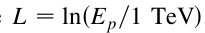

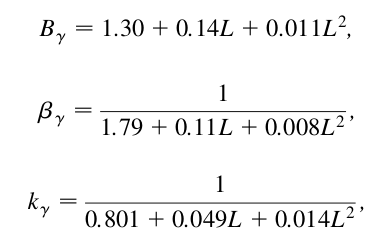

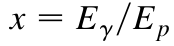

In [118]:
@u.quantity_input(E_proton=u.eV)
def L(E_proton):
  return (np.log(E_proton/u.TeV)).to(u.eV/u.eV)

@u.quantity_input(E_proton=u.eV)
def BGamma(E_proton):
  return (1.3 + 0.14*L(E_proton) + 0.011*(L(E_proton))**2).to(u.eV/u.eV)

@u.quantity_input(E_proton=u.eV)
def BetaGamma(E_proton):
  return (1/(1.79 + 0.11*L(E_proton) + 0.008*(L(E_proton))**2)).to(u.eV/u.eV)

@u.quantity_input(E_proton=u.eV)
def KGamma(E_proton):
  return (1/(0.801 + 0.049*L(E_proton) + 0.014*(L(E_proton))**2)).to(u.eV/u.eV)

@u.quantity_input(E_proton=u.eV, E_gamma=u.eV)
def x(E_proton, E_gamma):
  return (E_gamma/E_proton).to(u.eV/u.eV)


## Define the production rate of gamma rays
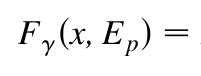

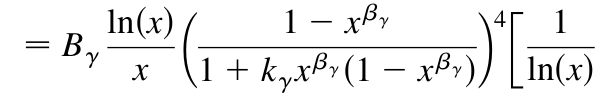
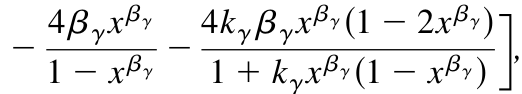

In [120]:
# BE CAREFUL (E_gamma cannot equal E_proton because a divide by zero error)
@u.quantity_input(E_proton=u.eV)
def gammaRayProductionRate(E_proton, E_gamma):
  xToBetaGamma = (x(E_proton, E_gamma))**BetaGamma(E_proton)

  first_part = BGamma(E_proton) * np.log(x(E_proton, E_gamma))/x(E_proton, E_gamma)
  second_part = ((1-xToBetaGamma) / (1+ KGamma(E_proton)*xToBetaGamma*(1-xToBetaGamma)))**4
  third_part = 1/np.log(x(E_proton, E_gamma)) - (4*BetaGamma(E_proton)*xToBetaGamma)/(1 - xToBetaGamma) - (4*KGamma(E_proton)*BetaGamma(E_proton)*xToBetaGamma * (1 - 2 * xToBetaGamma))/(1 + KGamma(E_proton) * xToBetaGamma * (1 - xToBetaGamma))

  return (first_part * second_part * third_part).to(u.eV/u.eV)

In [121]:
@u.quantity_input(E_proton=u.eV)
def CrossSection(E_proton):
  return (34.3 + 1.88*L(E_proton) + 0.25 * L(E_proton)**2) * u.mbarn

# cosmicRayCoeffient a fraction of the total SNR energy to get the cosmic ray energy budget only
@u.quantity_input(E_proton=u.eV, radial_distance=u.pc, time=u.yr)
def transport_function(E_proton, radial_distance, time, cosmicRayCoeffient=0.1, ESN=1e52*u.erg, alpha=2.5, E_max=5*u.PeV, E_min=1*u.GeV):
  return (((cosmicRayCoeffient*ESN*(-alpha + 2) * E_proton**(-alpha)) / (E_max**(-alpha+2) - E_min**(-alpha+2))) / u.m**3 ).to(1/(u.m**3 * u.eV))

In [139]:
# Testing
L(10*u.TeV)
BGamma(10*u.TeV)
BetaGamma(10*u.TeV)
KGamma(10*u.TeV)
x(10*u.TeV, 1*u.TeV)
# gammaRayProductionRate(10*u.TeV, 1*u.TeV)
# transport_function(10*u.TeV, 10 *u.pc, 1600*u.yr)
CrossSection(10*u.TeV)

<Quantity 39.9543345 mbarn>

In [212]:
# Numerical integral
E_logspace = np.logspace(np.log10(1e9), np.log10(5e15), num=1000)

def integrand_function(E_proton, E_gamma):
  return (CrossSection(E_proton) * transport_function(E_proton, 10*u.pc, 1000*u.yr) * gammaRayProductionRate(E_proton, E_gamma) / E_proton).to(1/(u.erg**2 * u.m))

def integrateForEGamma(E_gamma):
  # Preallocate the result array with the same length as E_logspace
  result_array = np.zeros_like(E_logspace) * u.erg**(-2) * u.m**(-1)

  # Convert E_logspace to astropy units in a vectorized manner
  E_proton_array = E_logspace * u.eV

  # Apply the integrand function in a vectorized manner to all proton energies
  result_array = integrand_function(E_proton_array, E_gamma)

  E_diff = np.diff(E_logspace)

  return np.sum(E_diff * result_array[1:])

E_gamma_logspace = np.logspace(np.log10(1e9), np.log10(5e15), num=500)
final_result_array = np.zeros_like(E_gamma_logspace) * u.erg**(-2) * u.m**(-1)
# Convert E_logspace to astropy units in a vectorized manner
E_gamma_array = E_gamma_logspace * u.eV

for i, E_gamma in enumerate(E_gamma_array):
    final_result_array[i] = integrateForEGamma(E_gamma)

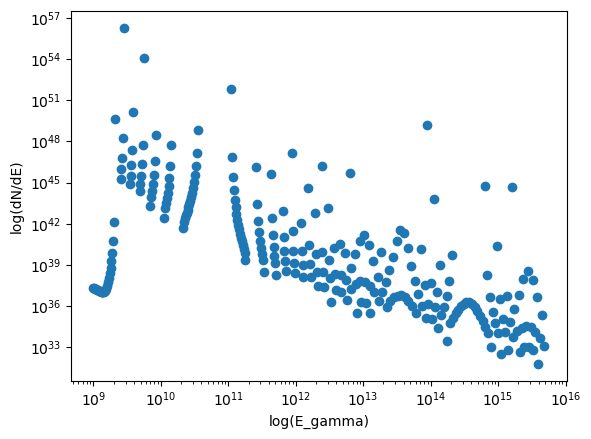

In [219]:
plt.figure()
plt.scatter(E_gamma_logspace, final_result_array)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("log(E_gamma)")
plt.ylabel("log(dN/dE)")
plt.show()

In [ ]:
# # Constructing the final function
# light_speed = 3e8 * u.m / u.s

# @u.quantity_input(E_proton=u.ev, E_gamma=u.eV, n_p=1/u.m**3, cloud_volume=u.m**3, dist_to_earth=u.pc)
# def calcRateOfChangeOfRaysNumberWithRespectToEnergy(E_proton, E_gamma, n_p, cloud_volume, dist_to_earth):
#   return (light_speed * n_p * cloud_volume / (4*np.pi*d^2))